In [ ]:
import datawrangler as dw
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

import warnings
import os
import pickle

from loader import DATA_DIR, load
from fitness import format_text

# Load in behavioral and fitness summaries

In [2]:
with open(os.path.join(DATA_DIR, 'behavioral_summary.pkl'), 'rb') as f:
    behavioral = pickle.load(f)
    
with open(os.path.join(DATA_DIR, 'fitness_summary.pkl'), 'rb') as f:
    fitness = pickle.load(f)

# Load in survey data

Also re-format columns for prettier printing

In [3]:
_, _, survey = load(recent=7, baseline=30)
survey = pd.DataFrame(data=survey.values, index=survey.index,
                      columns=[format_text(' '.join(c).replace(':', ' ')) for c in survey.columns])

# Set up exploratory correlation analysis

In [4]:
def nancorr(a, b):
    warnings.simplefilter('ignore') # turn off imputer warnings
    
    a = pd.DataFrame(data=np.float32(a.values), index=a.index, columns=a.columns)
    b = pd.DataFrame(data=np.float32(b.values), index=b.index, columns=b.columns)
    
    corrs = pd.DataFrame(index=a.columns, columns=b.columns, dtype=np.float32)
    for i in a.columns:
        for j in b.columns:
            inds = ~(np.isnan(np.array(a[i])) | np.isnan(np.array(b[j])))
            if np.sum(inds) == 0:
                corrs.loc[i, j] = np.nan
            else:
                try:
                    corrs.loc[i, j] = a[i].loc[inds].corr(b[j].loc[inds])
                except:
                    corrs.loc[i, j] = np.nan
    return corrs

In [5]:
def bootstrap_corrs(a, b, n_bootstraps=1000, correction_run=False):
    n_subjects = a.shape[0]
    assert b.shape[0] == n_subjects, 'a and b must have the same number of rows'
    
    corr_sum = pd.DataFrame(index=a.columns, columns=b.columns, data=np.zeros((a.shape[1], b.shape[1])))
    positive_counts = corr_sum.copy()
    negative_counts = corr_sum.copy()
    nan_counts = corr_sum.copy()
    
    correction = 0
    
    for n in range(n_bootstraps):
        sampled_subjects = np.random.choice(a.index.values, size=(n_subjects), replace=True)                  
        try:
            sampled_corrs = nancorr(a.loc[sampled_subjects], b.loc[sampled_subjects])
        except:
            correction += 1
            continue
        
        positive_counts += pd.DataFrame(index=a.columns, columns=b.columns,
                                        data=sampled_corrs > 0)
        negative_counts += pd.DataFrame(index=a.columns, columns=b.columns,
                                        data=sampled_corrs < 0)
        nan_counts += pd.DataFrame(index=a.columns, columns=b.columns,
                                   data=np.isnan(sampled_corrs))
        
        
        sampled_corrs[np.isnan(sampled_corrs)] = 0.0
        
        corr_sum += pd.DataFrame(index=a.columns, columns=b.columns,
                                 data=np.arctanh(sampled_corrs))
        
    
    if (not correction_run) and (correction > 0):
        cs, p, n, nn, crc = bootstrap_corrs(a, b, thresh=thresh, n_bootstraps=correction, correction_run=True)
        corr_sum += cs
        positive_counts += p
        negative_counts += n
        nan_counts += nn
        correction -= crc
    
    if correction_run:
        return corr_sum, positive_counts, negative_counts, nan_counts, correction
    
    if correction > 0:
        warnings.warn(f'Unable to run {correction} iterations-- inferring results from remaining {n_bootstraps - correction} iterations')
    
    c = np.tanh(np.divide(corr_sum.values, n_bootstraps - correction - nan_counts))
    #c[((positive_counts + correction + nan_counts) < thresh * n_bootstraps) & ((negative_counts + correction + nan_counts) < thresh * n_bootstraps)] = np.nan
    
    ps = pd.DataFrame(index=a.columns, columns=b.columns, data=1 - np.divide(np.maximum(positive_counts, negative_counts), positive_counts + negative_counts))
    return pd.DataFrame(index=a.columns,
                        columns=b.columns,
                        data=c), ps

In [6]:
def plot_corrmap(c, xlabel='', ylabel='', scale=1.7, pthresh=0.05, twotailed=True):
    if type(c) in [tuple, list]:
        c, ps = c
        
    else:
        ps = pd.DataFrame(np.zeros(shape=c.shape), index=c.index, columns=c.columns)
    
    if twotailed:
        correction = 2
    else:
        correction = 1
    c[ps > (pthresh / correction)] = np.nan
    
    fig, ax = plt.subplots(figsize=np.divide(c.shape, scale))
    cmap = sns.color_palette('vlag', as_cmap=True)
    
    mask = np.zeros_like(c)
    mask[np.triu_indices_from(mask, 1)] = True    
    
    sns.heatmap(c, cmap=cmap, center=0.00, annot=True, fmt ='0.2f',
                linewidths=0.5, linecolor='black', cbar=False, mask=1-mask,
                vmin=-1.0, vmax=1.0, ax=ax, square=True)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    ax.plot([xlim[1], xlim[1]], ylim, c='black', linewidth=2)
    ax.plot(xlim, [ylim[0], ylim[0]], c='black', linewidth=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if len(xlabel) > 0:
        plt.xlabel(xlabel, fontsize=14)
    if len(ylabel) > 0:
        plt.ylabel(ylabel, fontsize=14)
    
    
    
    
    for i, idx in enumerate(c.index):
        for col in c.columns:                    
            if ps.loc[idx, col] * correction <= pthresh:
                print(f'corr({idx}, {col}): r = {c.loc[idx, col]}, p = {ps.loc[idx, col] * correction}')

## Correlate behavioral variables with other behavioral variables

In [7]:
n_bootstraps=10000

corr(Free recall (immediate), Free recall (immediate)): r = 1.0, p = 0.0
corr(Free recall (immediate), Free recall (delayed)): r = 0.7685494873591465, p = 0.0
corr(Free recall (immediate), Foreign language flashcards (immediate)): r = 0.5254375047394411, p = 0.0016000000000000458
corr(Free recall (immediate), Foreign language flashcards (delayed)): r = 0.4821625276664844, p = 0.0032000000000000917
corr(Free recall (delayed), Free recall (immediate)): r = 0.7685494873591465, p = 0.0
corr(Free recall (delayed), Free recall (delayed)): r = 1.0, p = 0.0
corr(Free recall (delayed), Foreign language flashcards (immediate)): r = 0.3692767659811006, p = 0.008599999999999941
corr(Free recall (delayed), Foreign language flashcards (delayed)): r = 0.29829015316154284, p = 0.02980000000000005
corr(Naturalistic recall (immediate), Naturalistic recall (immediate)): r = 1.0, p = 0.0
corr(Naturalistic recall (immediate), Naturalistic recall (delayed)): r = 0.2551184250826923, p = 0.0007999999999999119

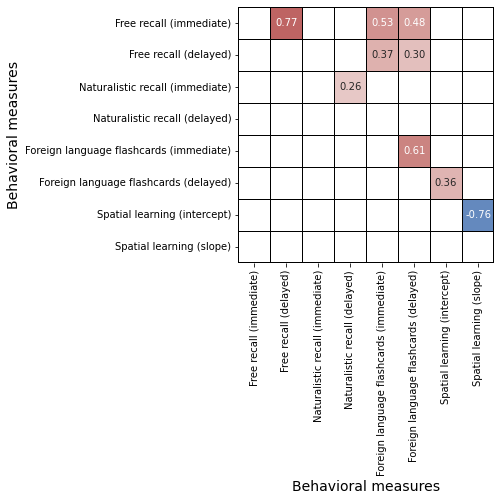

In [8]:
plot_corrmap(bootstrap_corrs(behavioral, behavioral, n_bootstraps=n_bootstraps), xlabel='Behavioral measures', ylabel='Behavioral measures')
plt.savefig('behavior_behavior_correlations.pdf')

corr(BMI, BMI): r = 1.0, p = 0.0
corr(BMI, body fat): r = 0.6595350492920297, p = 0.035600000000000076
corr(BMI, weight): r = 0.9105894866084728, p = 0.0
corr(body fat, BMI): r = 0.6595350492920297, p = 0.035600000000000076
corr(body fat, body fat): r = 1.0, p = 0.0
corr(body fat, resting heart rate: recent/baseline): r = nan, p = 0.03953938652807509
corr(body fat, peak HR: recent/baseline): r = nan, p = 0.032043849478233355
corr(weight, BMI): r = 0.9105894866084728, p = 0.0
corr(weight, weight): r = 1.0, p = 0.0
corr(resting heart rate: recent, resting heart rate: recent): r = 1.0, p = 0.0
corr(resting heart rate: recent, sleep duration: recent): r = 1.0, p = 0.0
corr(resting heart rate: recent, sleep duration: recent/baseline): r = -1.0, p = 0.0
corr(resting heart rate: recent, high intensity activity: recent): r = -0.38767958884454096, p = 0.0374000000000001
corr(resting heart rate: recent, fat burn HR: recent): r = 0.6987849836893367, p = 0.00039999999999995595
corr(resting heart r

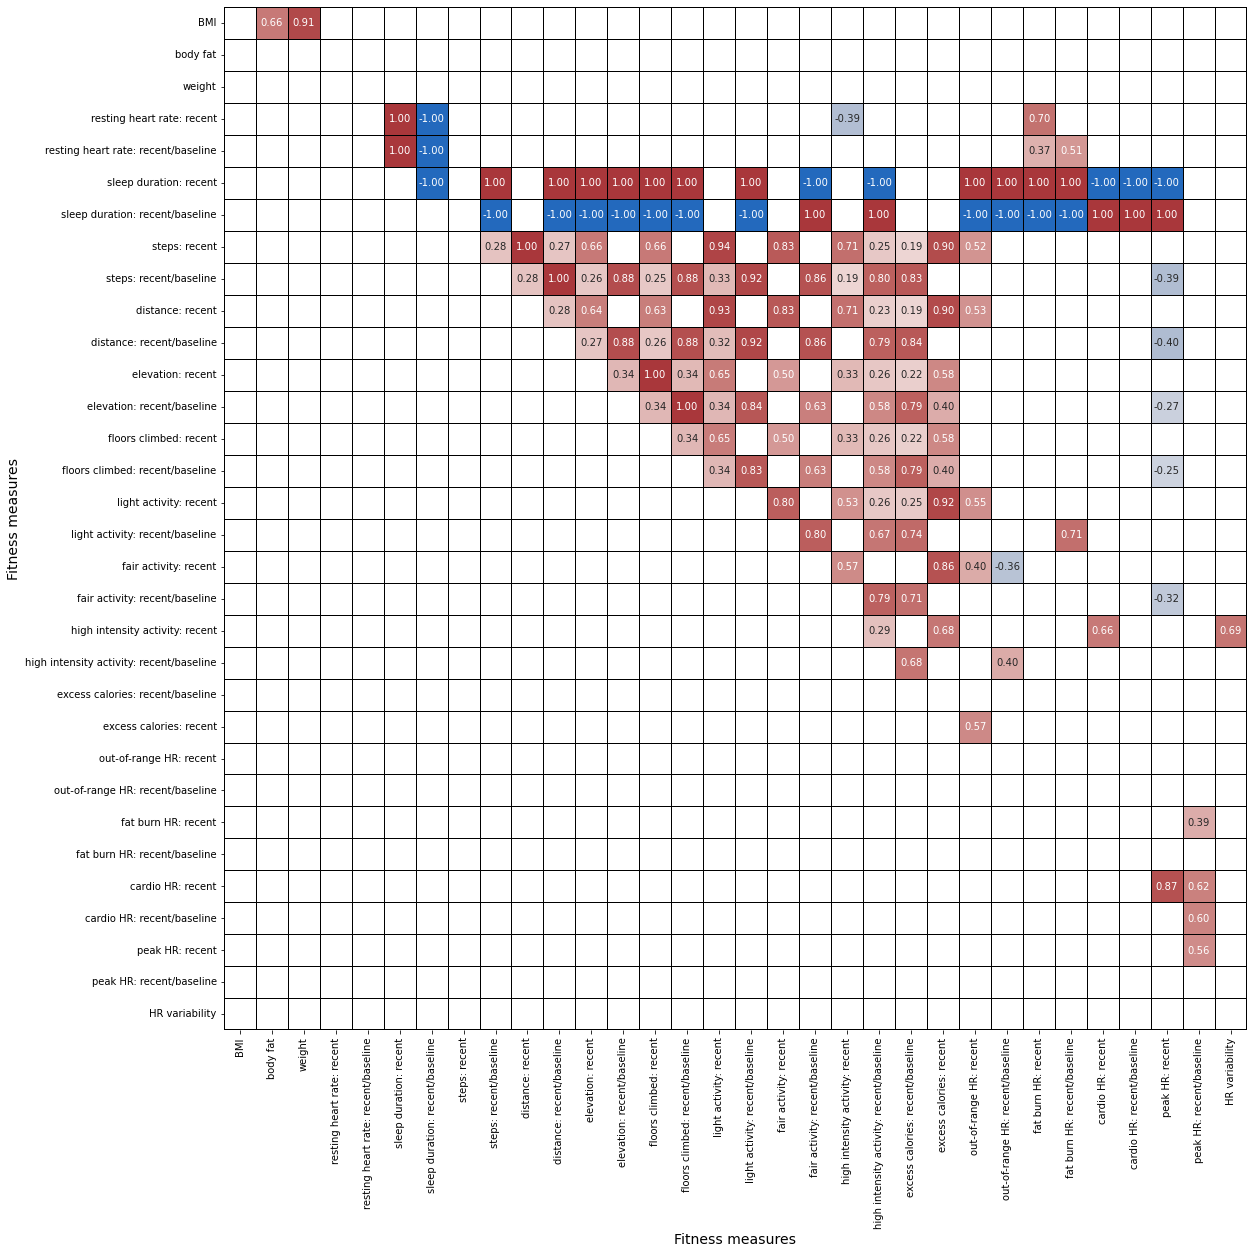

In [9]:
plot_corrmap(bootstrap_corrs(fitness, fitness, n_bootstraps=n_bootstraps), xlabel='Fitness measures', ylabel='Fitness measures')
plt.savefig('fitness_fitness_correlations.pdf')

corr(Age, Age): r = 1.0, p = 0.0
corr(Age, Race other): r = -0.1471918553852566, p = 0.0
corr(Age, Degree associate's
degree): r = 0.2696864712102118, p = 0.008200820082008287
corr(Age, Degree some college): r = -0.21551096607250006, p = 0.0012000000000000899
corr(Age, Number fluent
languages): r = -0.2041133534207571, p = 0.006599999999999939
corr(Age, Health and wellness
anxiety or depression): r = -0.19711209189300125, p = 0.0
corr(Age, Health and wellness
high blood pressure): r = 0.18613942042438578, p = 0.0
corr(Age, Health and wellness
bipolar): r = -0.15105200784146544, p = 0.0
corr(Age, Health and wellness
hypothyroid): r = 0.04221396703566811, p = 0.0009573958831976537
corr(Age, Health and wellness
unspecified
medications): r = 0.10211528735240742, p = 0.0
corr(Age, Current stress): r = -0.2030348584099234, p = 0.023600000000000065
corr(Age, Current / typical
stress): r = 0.06764739083433685, p = 0.0
corr(Age, Coffee intake): r = 0.20560684326476994, p = 0.03760000000000008
c

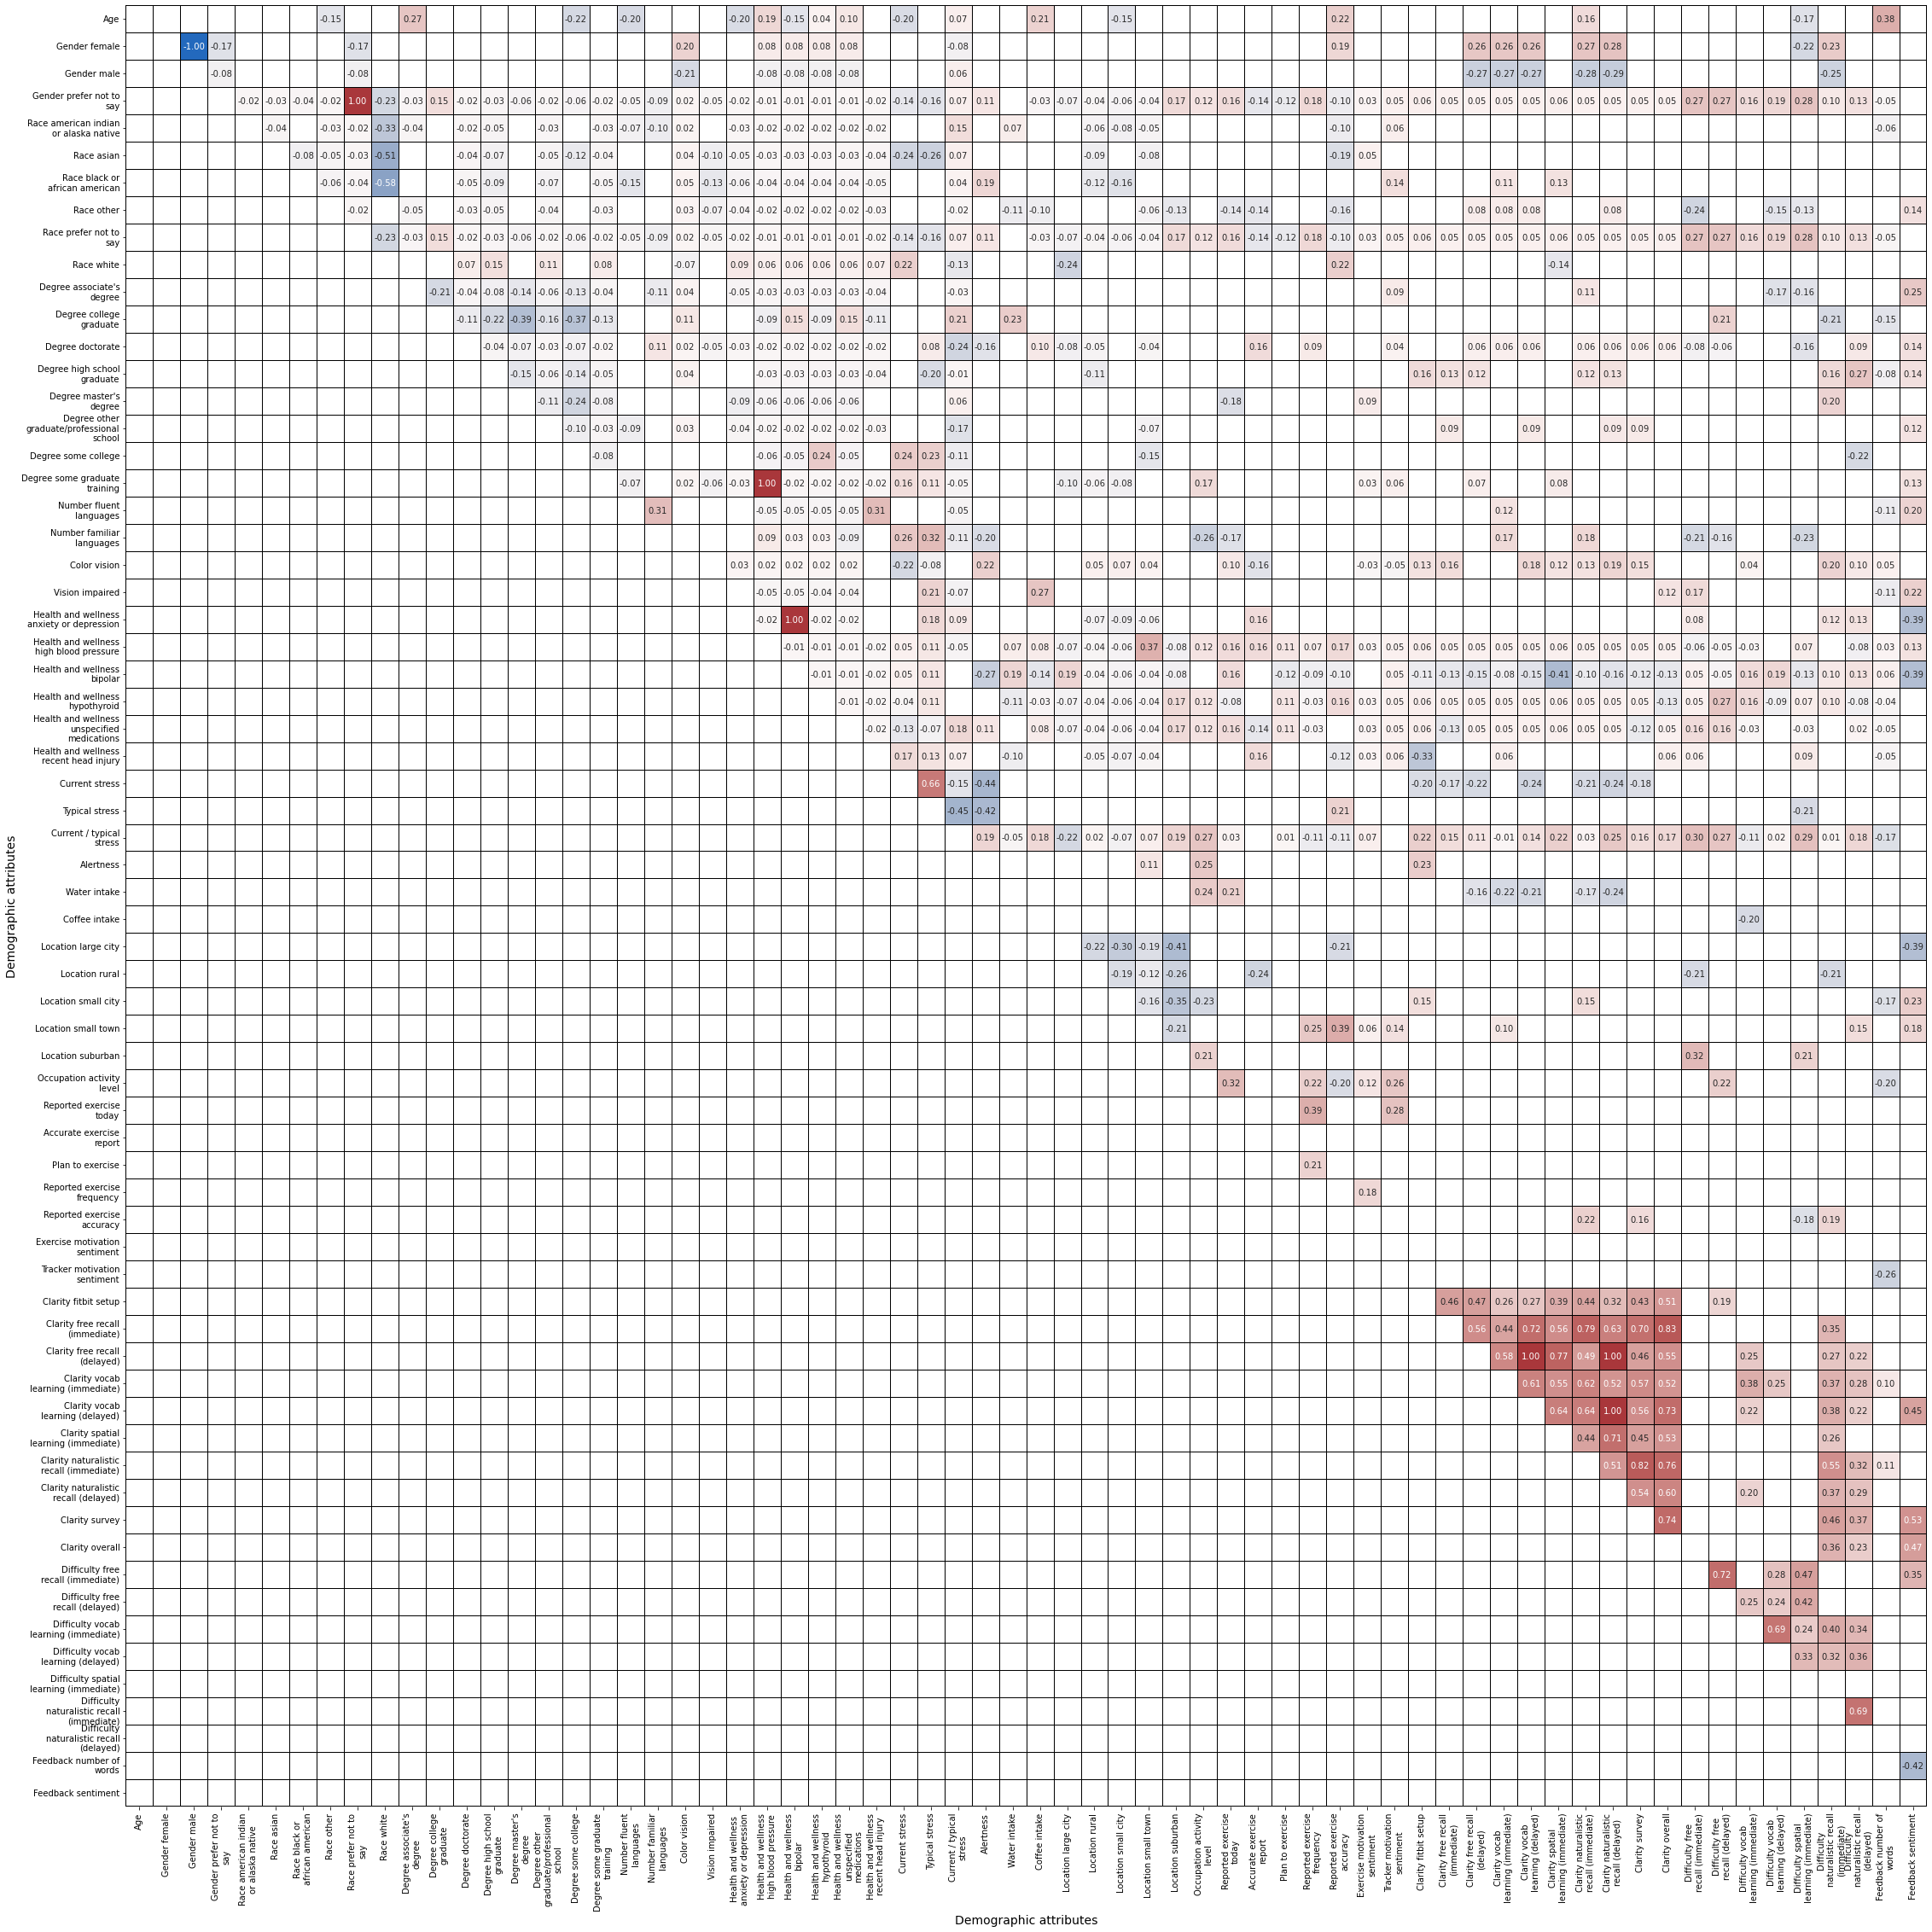

In [10]:
plot_corrmap(bootstrap_corrs(survey, survey, n_bootstraps=n_bootstraps), xlabel='Demographic attributes', ylabel='Demographic attributes')
plt.savefig('survey_survey_correlations.pdf')

corr(Free recall (immediate), Gender prefer not to
say): r = 0.09840970346564178, p = 0.0
corr(Free recall (immediate), Race asian): r = -0.19930243956571167, p = 0.002401440864518767
corr(Free recall (immediate), Race prefer not to
say): r = 0.09840970346564178, p = 0.0
corr(Free recall (immediate), Color vision): r = 0.22479785856424522, p = 0.0
corr(Free recall (immediate), Health and wellness
high blood pressure): r = -0.11064744771103639, p = 0.0
corr(Free recall (immediate), Health and wellness
bipolar): r = 0.10711904438608615, p = 0.0
corr(Free recall (immediate), Health and wellness
hypothyroid): r = -0.16496493750810812, p = 0.0
corr(Free recall (immediate), Health and wellness
unspecified
medications): r = 0.16154471109926427, p = 0.0
corr(Free recall (immediate), Health and wellness
recent head injury): r = -0.05149232742958765, p = 0.017025192683768564
corr(Free recall (immediate), Clarity vocab
learning (immediate)): r = 0.32778054621910196, p = 0.006000000000000005
corr(

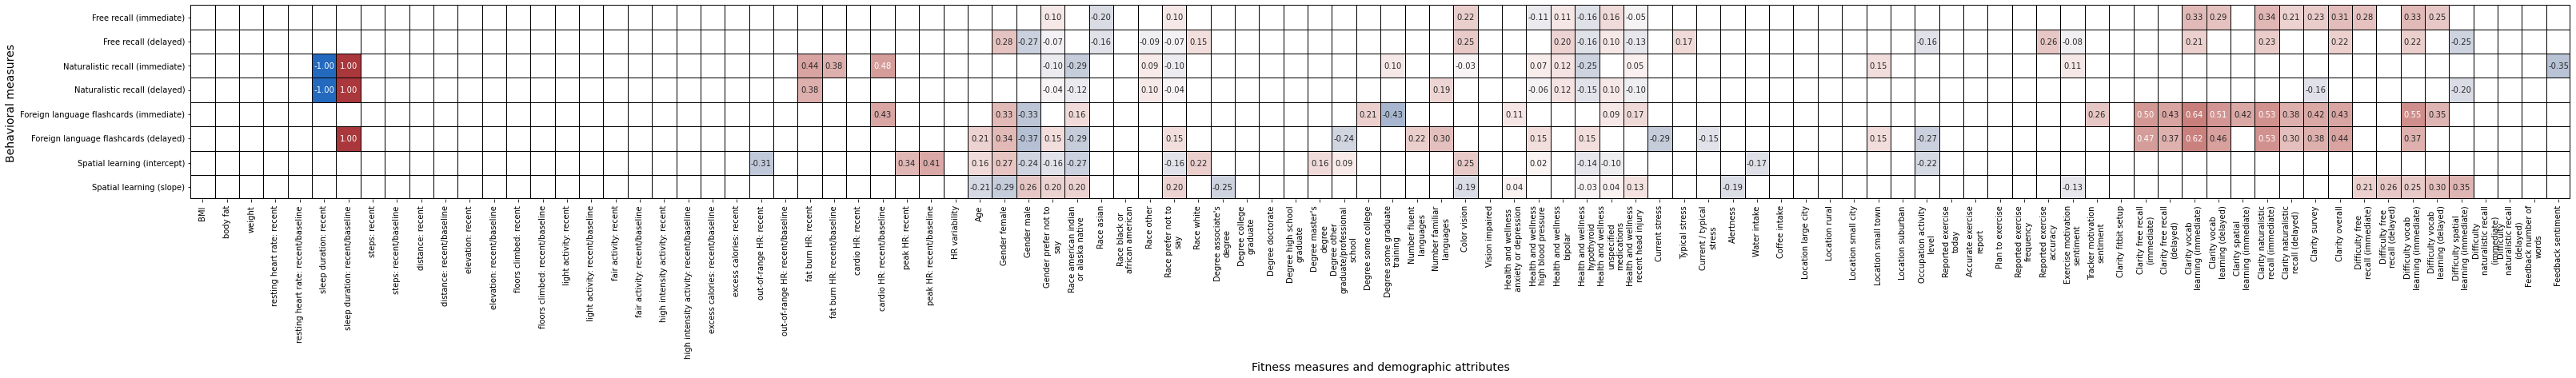

In [11]:
plot_corrmap(bootstrap_corrs(behavioral, pd.concat([fitness, survey], axis=1), n_bootstraps=n_bootstraps),
             xlabel='Fitness measures and demographic attributes', ylabel='Behavioral measures', scale=0.15)
plt.savefig('behavior_fitness+survey_correlations.pdf')